<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Preprocessing-pipeline" data-toc-modified-id="Preprocessing-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing pipeline</a></span></li></ul></div>

# Построение моделей

## Импорт библиотек

In [142]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
sns.set_palette("pastel")

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer
import catboost as cb
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate

import json

Загрузим полный датасет

In [191]:
#загрузка полного датасета и словаря с индексами для CV
data_full = pd.read_csv('data_full.csv')
data_full_dates = pd.read_csv('data_full_dates.csv')

# Opening JSON file
with open('data_full_dict.json') as json_file:
    data_full_cv = json.load(json_file)
json_file.close()

In [117]:
class CustomCrossValidation:
    
    def __init__(self, dict_cv):
        self.dict_cv = dict_cv
    
    def split(self, X=None, y=None, groups=None):
        for i in range(1, 4):
            training_indices = self.dict_cv[f'train_{i}'][-3]
            test_indices = self.dict_cv[f'test_{i}'][-3]
#         training_indices = self.dict_cv['train_1'][:3]
#         test_indices = self.dict_cv['test_1'][:3]      

            yield training_indices, test_indices

---

## Preprocessing pipeline

* Закодируем категориальные переменные через OneHotEncoder
* Сделаем scaling для числовых переменных

In [140]:
X_train = data_full.drop(columns=['target'])
y_train = data_full['target']

In [128]:
#create an instance of scaling and encoding the features

#data transformation objects
#using OE (not OHE) for tree-like models (incl boosting) because two much unuique values -> 
#to many transformed columns -> longer time and OHE for linear regression
sc = StandardScaler()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# ohe = OneHotEncoder(handle_unknown='ignore')

#list of numeric and non-numeric features
    #holiday, days_ny, days_paskha - not encoding      

features_n = ['day',
            'dayofweek',
            'ma_3d',
            'ma_6d',
            'ma_9d',
            'ma_12d',
            'ma_15d',
            'max_3d',
            'max_6d',
            'max_9d',
            'max_12d',
            'max_15d',
            'min_3d',
            'min_6d',
            'min_9d',
            'min_12d',
            'min_15d',
            'sales_0days_ago',
            'sales_1days_ago',
             'sales_2days_ago',
             'sales_3days_ago',
             'sales_4days_ago',
             'sales_5days_ago',
             'sales_6days_ago',
             'sales_7days_ago',
             'sales_8days_ago',
             'sales_9days_ago',
             'sales_10days_ago',
             'sales_11days_ago',
             'sales_12days_ago',
             'sales_13days_ago',
             'sales_14days_ago',
             'sales_15days_ago',
             'sales_16days_ago',
             'sales_17days_ago',
             'sales_18days_ago',
             'sales_19days_ago',
             'sales_20days_ago',
             'sales_21days_ago']

features_str = ['st_id',
                'pr_sku_id',
                'st_city_id',
                'st_division_code',
                'st_type_format_id',
                'st_type_loc_id',
                'st_type_size_id',
                'pr_group_id',
                'pr_cat_id',
                'pr_subcat_id',
                'pr_uom_id']

#combine into one single object
ct_oe = make_column_transformer(
    (sc, features_n),
    (oe, features_str),
    remainder='passthrough'
)

# #combine into one single object
# ct_ohe = make_column_transformer(
#     (sc, features_n),
#     (ohe, features_str),
#     remainder='passthrough'
# )


#fit the transformers
ct_oe.fit(X_train)
# ct_ohe.fit(data_full)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['day', 'dayofweek', 'ma_3d', 'ma_6d', 'ma_9d',
                                  'ma_12d', 'ma_15d', 'max_3d', 'max_6d',
                                  'max_9d', 'max_12d', 'max_15d', 'min_3d',
                                  'min_6d', 'min_9d', 'min_12d', 'min_15d',
                                  'sales_0days_ago', 'sales_1days_ago',
                                  'sales_2days_ago', 'sales_3days_ago',
                                  'sales_4days_ago', 'sales_5days_a...
                                  'sales_6days_ago', 'sales_7days_ago',
                                  'sales_8days_ago', 'sales_9days_ago',
                                  'sales_10days_ago', 'sales_11days_ago',
                                  'sales_12days_ago', ...]),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['st_id', 'pr_sku_id', 'st_city_id',
                                  'st_division_code', 'st_type_format_id',
                                  'st_type_loc_id', 'st_type_size_id',
                                  'pr_group_id', 'pr_cat_id', 'pr_subcat_id',
                                  'pr_uom_id'])])

Создадим метрику

In [129]:
#функция, которая будет расчитывать метрику sMAPE

def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true)+0.0000000000001)

In [169]:
class custom_wape:
    
    def get_final_error(self,error,weight):
        return error
    
    def is_max_optimal(self):
        return False
    
    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        
        return sum(abs(y_true-y_pred))/sum(abs(y_true)+0.0000000000001), 0.0

In [163]:
custom_cv = CustomCrossValidation(dict_cv=data_full_cv)

In [164]:
#sklearn make_scorer for the sMAPE
scorer_wape = make_scorer(wape, greater_is_better=False)

In [175]:
#define CatBoost model
model = cb.CatBoostRegressor(random_state=99, verbose=1, eval_metric=custom_wape(), iterations=50)

In [176]:
#создадим пайплайн, который будет выполнять (1) трансформацию данных и затем (2) обучать модель
#pipe = make_pipeline(ct_oe, cb)

In [177]:
custom_cv = CustomCrossValidation(dict_cv=data_full_cv)

In [178]:
%%time

# #create the dictionary for model hyperparameters
# hp = {  'learning_rate': [0.1, 0.03],
#         'depth': [2, 4, 6, 8]}

#search hyperparameters
# grid = GridSearchCV(estimator=model,
#                     param_grid = hp,
#                     cv = custom_cv,
#                     scoring=scorer_wape)

ds = cb.Pool(X_train, label=y_train, cat_features=features_str)
model.fit(ds)

C:\Users\yanis\anaconda3\envs\ds_practicum_env\lib\site-packages\catboost\core.py:1953: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.5
0:	learn: 0.8260819	total: 1.87s	remaining: 1m 31s
1:	learn: 0.5088869	total: 3.82s	remaining: 1m 31s
2:	learn: 0.2928057	total: 5.53s	remaining: 1m 26s
3:	learn: 0.2047349	total: 7.24s	remaining: 1m 23s
4:	learn: 0.1464263	total: 9.14s	remaining: 1m 22s
5:	learn: 0.1215470	total: 10.7s	remaining: 1m 18s
6:	learn: 0.1215186	total: 12.6s	remaining: 1m 17s
7:	learn: 0.1108632	total: 14.4s	remaining: 1m 15s
8:	learn: 0.1102024	total: 16.2s	remaining: 1m 13s
9:	learn: 0.1045587	total: 17.6s	remaining: 1m 10s
10:	learn: 0.1040084	total: 19.2s	remaining: 1m 8s
11:	learn: 0.1036546	total: 21.1s	remaining: 1m 6s
12:	learn: 0.0913132	total: 23s	remaining: 1m 5s
13:	learn: 0.0903088	total: 24.9s	remaining: 1m 4s
14:	learn: 0.0900973	total: 26.6s	remaining: 1m 2s
15:	learn: 0.0587779	total: 28.7s	remaining: 1m 1s
16:	learn: 0.0531738	total: 30.4s	remaining: 59s
17:	learn: 0.0531414	total: 32.6s	remaining: 58s
18:	learn: 0.0531375	total: 35.6s	remaining: 58.2s
19:	learn: 0

In [181]:
pred = model.predict(X_train)

<AxesSubplot:ylabel='target'>

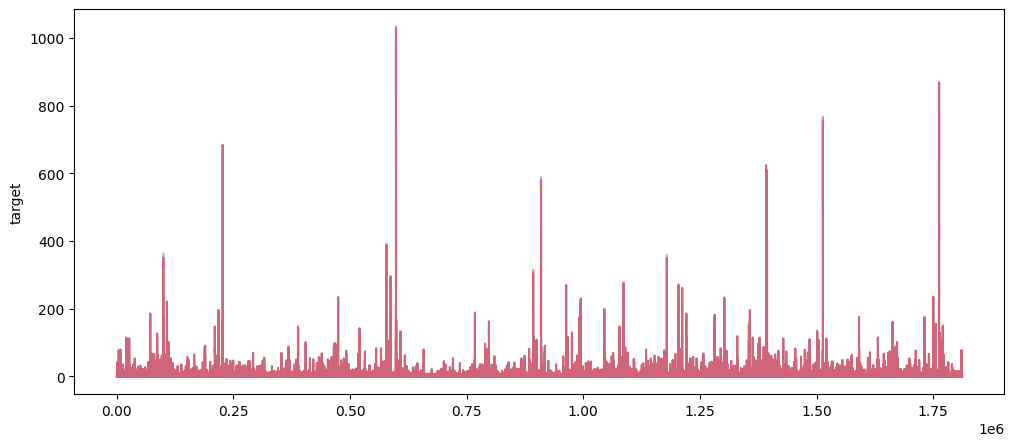

In [184]:
plt.figure(figsize=(12,5))

sns.lineplot(data=pred)
sns.lineplot(data=y_train, color='red', alpha=0.5)

In [187]:
pred

array([ 0.00318259,  0.00318259,  0.00318259, ..., -0.00301014,
       -0.00301014, -0.00301014])

In [199]:
data_full['pred'] = pred
data_full['date'] = pd.to_datetime(data_full_dates['date'], format='%Y-%m-%d')

In [206]:
pivot = pd.pivot_table(data=data_full,
              index='date',
              values=['target', 'pred'],
              aggfunc='sum').sort_values(by='date')

<AxesSubplot:xlabel='date'>

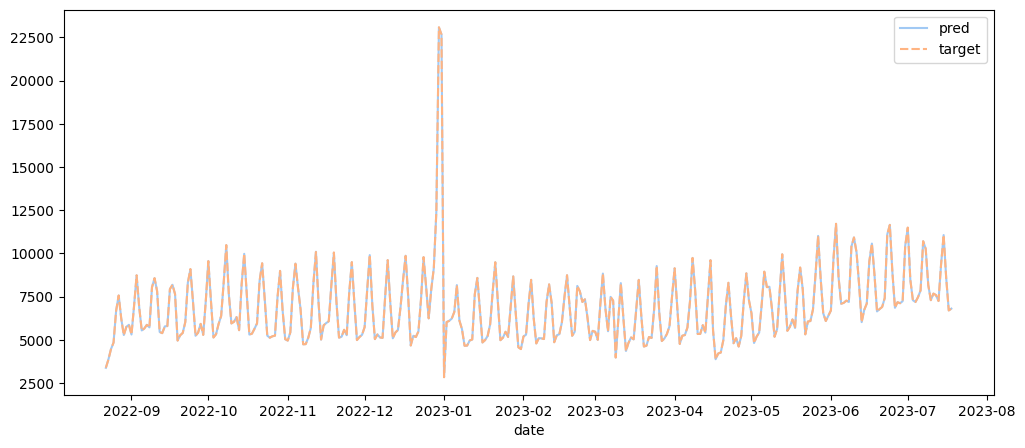

In [208]:
plt.figure(figsize=(12,5))
sns.lineplot(data=pivot)